In [16]:
import networkx as nx
import musicbrainzngs as mb 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import igraph as ig
from community import community_louvain as com
from wordcloud import WordCloud

Lo que hice fue pasar la red multienlace a una red pesada pero se perdieron los atributos. Cuando queramos darle un caracter temporal a la detección de comunidades deberiamos incorporarselo, por ahora los resultados que se muestran preliminarmente no los tienen en cuenta


In [17]:

i = 1496
with open(f"red_final/Iteracion {i}/red_final_hasta_indice_{i}.gpickle", "rb") as f:
    red_artistas_1 = pickle.load(f)
red_artistas= nx.Graph(red_artistas_1)
red_artistas_ig = ig.Graph.from_networkx(red_artistas)

In [48]:
lista_enlaces = list(red_artistas_1.edges())
mayor_grado = 0
for i in red_artistas_1.nodes():
    grado_i = red_artistas_1.degree(i)
    if grado_i > mayor_grado:
        mayor_grado += grado_i
        aristas_mayor_grado = i
print(aristas_mayor_grado)
red_pesada = nx.MultiGraph()
red_pesada.add_edges_from(lista_enlaces)
print(red_pesada.degree("Francisco Canaro"))



Francisco Canaro
1260


In [18]:
def red_pesada(red_multienlaces):
    red_pesada = nx.Graph()
    artistas = red_multienlaces.nodes()
    red_pesada.add_nodes_from(artistas)
    for enlace in red_multienlaces.edges():
        try:
            red_pesada[enlace[0]][enlace[1]]['weight'] += 1
        except KeyError:
            red_pesada.add_edge(enlace[0],enlace[1],weight=1)
    return red_pesada

G = red_pesada(red_artistas_1)

print(G.nodes['Bizarrap'])

{}


In [19]:
i = 0
for enlace in red_artistas_1.edges():
    if enlace[0] == 'Bizarrap' or enlace[1] == 'Bizarrap':
        i+=1
print(i)

59


In [3]:
# between = red_artistas_ig.community_edge_betweenness(clusters = None, directed = False, weights = True) #Betweeness
# fast_greedy = red_artistas_ig.community_fastgreedy(weights = True) #Fastgreedy
infomap = red_artistas_ig.community_infomap() #Infomap   
louvain = com.best_partition(red_artistas) #Louvain

In [10]:
# Función para llevar el objeto vertex cluster a diccionario
def cluster_to_dict(cluster, g):
    dic = {}
    for i, c in enumerate(sorted(list(cluster), key = len, reverse = True)):
        for n in c:
            dic[g.vs[n]['_nx_name']] = i
    return dic


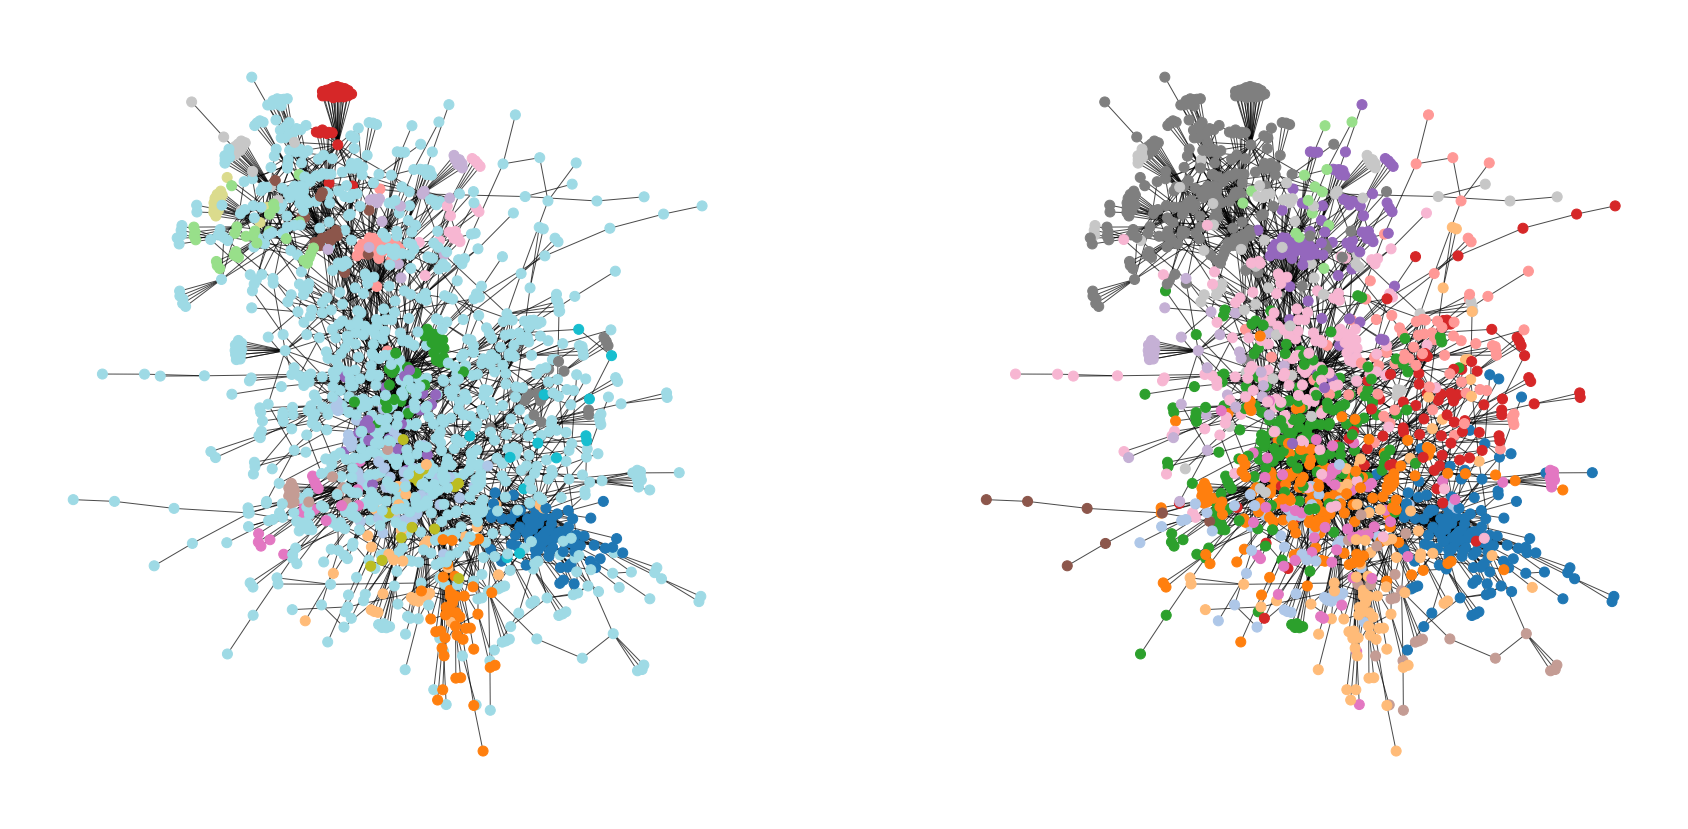

In [15]:
pos = nx.layout.fruchterman_reingold_layout(red_artistas)
dic_louvain = com.best_partition(red_artistas)
dic_infomap = cluster_to_dict(infomap, red_artistas_ig)
particiones = [ dic_infomap, dic_louvain]

fig, axs = plt.subplots(1, 2, figsize = (30, 15))

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(red_artistas,
                           pos = pos,
                           node_color = [plt.get_cmap('tab20')(particiones[i][v]) for v in red_artistas.nodes()],
                           ax = ax,
                           node_size = 100)
    nx.draw_networkx_edges(red_artistas,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    ax.axis('off')

plt.show()

Creo un WordCloud con las primeras 5 comunidades por cada algoritmo y agarro de cada comunidad los artistas con mayor grado

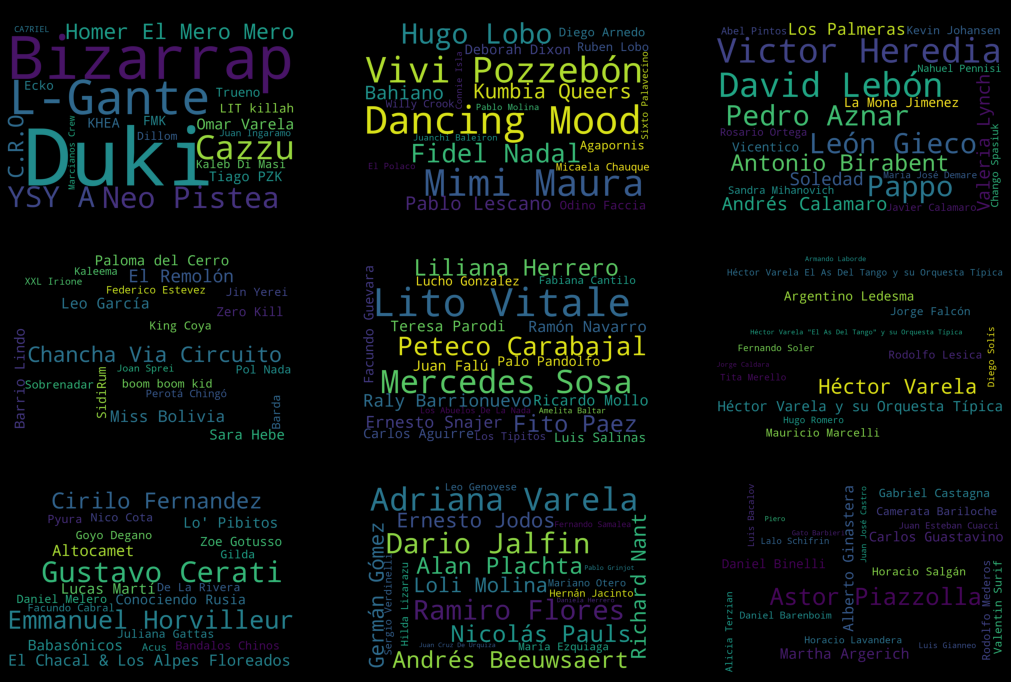

In [66]:
particion = dic_louvain
wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'black',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds
n = len(particion.values())
 # Recorro los clusters sin repetir
# for cluster in range(n): 

fig, axs = plt.subplots(3,3, figsize = (18,12),facecolor='black')

for cluster, ax in enumerate(fig.axes):
  #Ordeno los artistas de cada cluster a partir de su grado
  nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
  grados_del_cluster = [(node,val) for (node, val) in red_artistas.degree() if node in nodos_en_cluster]
  dict_artistas_del_cluster =dict(sorted(grados_del_cluster, key=lambda x: x[1], reverse=True))
  wc = WordCloud(**wc_atributos).generate_from_frequencies(dict_artistas_del_cluster)
  ax.set_title(f'Cluster {cluster}')
  ax.imshow(wc)
  ax.axis('off')

  